In [1]:
from netCDF4 import Dataset, Variable
import matplotlib.path as mpath
import cartopy
import xarray
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
import matplotlib.ticker as mticker
import os
import nctoolkit as nct
import regex
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
from cartopy.util import add_cyclic_point
from matplotlib import colors
import geopandas as gpd
import shapely.geometry as shp
import shapely.ops as ops
import rioxarray
import pyproj
import pandas as pd
from matplotlib.offsetbox import AnchoredText

2 files were created by nctoolkit in prior or current sessions. Consider running deep_clean!
nctoolkit is using Climate Data Operators version 1.9.8


In [2]:
nct.deep_clean()

In [3]:
os.chdir('/media/jasmine/Album/Project/')
print(os.getcwd())

/media/jasmine/Album/Project


In [4]:
variable = "intpp"
print(variable)
model = "CMCC-ESM2"
print(model)
experiment = "ssp585"
print(experiment)
freq = "Omon"
print(freq)

intpp
CMCC-ESM2
ssp585
Omon


In [5]:
nc = Dataset("Data/Raw/intpp_Omon_CMCC-ESM2_ssp585_r1i1p1f1_gn_201501-210012.nc")
unit = getattr(nc.variables[variable], "units")
unit

'mol m-2 s-1'

## Interpolation


In [6]:
for file in os.listdir("Data/Raw/"):
    if file.startswith("{}_{}_{}_{}".format(variable, freq, model, experiment)):
        print(file)

print("\n")

for file in os.listdir("Data/Raw/"):
    if file.startswith("{}_{}_{}_historical".format(variable, freq, model)):
        print(file)

intpp_Omon_CMCC-ESM2_ssp585_r1i1p1f1_gn_201501-210012.nc


intpp_Omon_CMCC-ESM2_historical_r1i1p1f1_gn_185001-201412.nc


In [7]:
!cdo remapdis,r360x180 Data/Raw/intpp_Omon_CMCC-ESM2_ssp585_r1i1p1f1_gn_201501-210012.nc Data/{variable}_{model}_{experiment}_remapped.nc

cdo    remapdis: Distance-weighted average weights from curvilinear (362x292) to lonlat (360x180) grid, with source mask (65262)
cdo    remapdis:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    remapdis: Processed 1 variable over 1032 timesteps [12.30s 209MB].


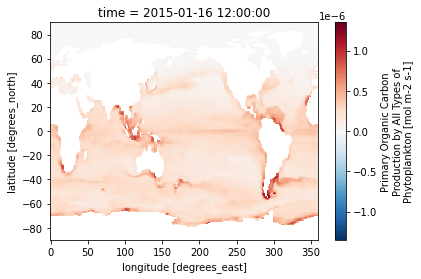

In [8]:
nc = xarray.open_dataset("Data/{}_{}_{}_remapped.nc".format(variable, model, experiment))
nc = nc.sel(time = "2015-01")
nc[variable].plot()

In [9]:
!cdo remapdis,r360x180 Data/Raw/intpp_Omon_CMCC-ESM2_historical_r1i1p1f1_gn_185001-201412.nc Data/{variable}_{model}_historical_remapped.nc

cdo    remapdis: Distance-weighted average weights from curvilinear (362x292) to lonlat (360x180) grid, with source mask (65262)
cdo    remapdis:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    remapdis: Processed 1 variable over 1980 timesteps [22.10s 221MB].


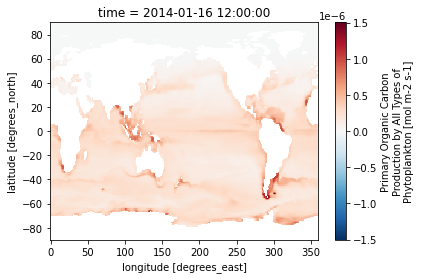

In [10]:
nc = xarray.open_dataset("Data/{}_{}_historical_remapped.nc".format(variable, model))
nc = nc.sel(time = "2014-01")
nc[variable].plot()

## Sea ice selection

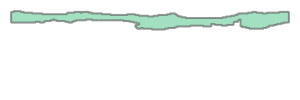

In [28]:
shape = gpd.read_file("Shapes/{}_extended_ice_margin.shp".format(model), crs = "EPSG:4326")
shape['geometry'][0]

In [29]:
ice = gpd.GeoSeries(shape['geometry'][0])

##### ssp585

In [30]:
nc = xarray.open_dataset("Data/{}_{}_{}_remapped.nc".format(variable, model, experiment))
nc = nc.drop_vars("time_bnds")
nc

<xarray.Dataset>
Dimensions:  (time: 1032, lon: 360, lat: 180)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    intpp    (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Wed Aug 03 10:52:01 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            intpp
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/045fe0c8-76be-44ac-8b8a-2c48f9dd3910
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [31]:
# Preparing nc file format for cropping
nc.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
nc.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:      (time: 1032, lon: 360, lat: 180)
Coordinates:
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    spatial_ref  int64 0
Data variables:
    intpp        (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Wed Aug 03 10:52:01 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            intpp
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/045fe0c8-76be-44ac-8b8a-2c48f9dd3910
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [32]:
clipped = nc.rio.clip(ice.geometry.values, crs = 4326, drop = False, all_touched = True)

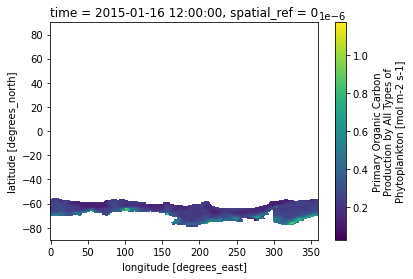

In [16]:
plot = clipped.sel(time = "2015-01")
plot[variable].plot()

In [17]:
clipped.to_netcdf(path = "Data/{}_{}_{}_cropped.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

##### historical


In [18]:
nc = xarray.open_dataset("Data/{}_{}_historical_remapped.nc".format(variable, model))
nc = nc.drop_vars("time_bnds")
nc

<xarray.Dataset>
Dimensions:  (time: 1980, lon: 360, lat: 180)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    intpp    (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Wed Aug 03 10:52:46 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variable_id:            intpp
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/f9aad0a5-1554-4d4b-9056-5578caee367d
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [19]:
# Preparing nc file format for cropping
nc.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
nc.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:      (time: 1980, lon: 360, lat: 180)
Coordinates:
  * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    spatial_ref  int64 0
Data variables:
    intpp        (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Wed Aug 03 10:52:46 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variable_id:            intpp
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/f9aad0a5-1554-4d4b-9056-5578caee367d
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [20]:
clipped = nc.rio.clip(ice.geometry.values, crs = 4326, drop = False, all_touched = True)

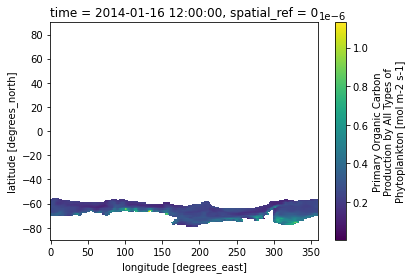

In [21]:
plot = clipped.sel(time = "2014-01")
plot[variable].plot()

In [22]:
clipped.to_netcdf(path = "Data/{}_{}_historical_cropped.nc".format(variable, model), mode = "w", format = "NETCDF4")

## Cropping by export

#### Calculate percentage difference 

##### historical

In [23]:
# Mean of historial last 20 years
historical = xarray.open_dataset("Data/{}_{}_historical_cropped.nc".format(variable, model))
historical

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360, time: 1980)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    spatial_ref  int64 ...
    intpp        (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Wed Aug 03 10:52:46 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variable_id:            intpp
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/f9aad0a5-1554-4d4b-9056-5578caee367d
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [24]:
historical_cropped = historical.sel(time=slice('1995-01', '2014-12'))
historical_cropped = historical_cropped.drop_vars("spatial_ref")
historical_cropped

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 240)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    intpp    (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Wed Aug 03 10:52:46 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variable_id:            intpp
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/f9aad0a5-1554-4d4b-9056-5578caee367d
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [25]:
historical_mean = historical_cropped.mean("time")
historical_mean

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    intpp    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

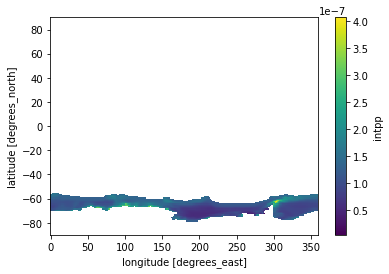

In [26]:
historical_mean[variable].plot()

In [27]:
historical_mean.to_netcdf(path = "Data/{}_{}_historical_20yr.nc".format(variable, model), mode = "w", format = "NETCDF4")

##### ssp585

In [28]:
# Mean of ssp585 last 20 years
new = xarray.open_dataset("Data/{}_{}_{}_cropped.nc".format(variable, model, experiment))
new

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360, time: 1032)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    spatial_ref  int64 ...
    intpp        (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Wed Aug 03 10:52:01 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            intpp
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/045fe0c8-76be-44ac-8b8a-2c48f9dd3910
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [29]:
new_cropped = new.sel(time=slice("2081-01","2100-12"))
new_cropped = new_cropped.drop_vars("spatial_ref")
new_cropped

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 240)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 2081-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    intpp    (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Wed Aug 03 10:52:01 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            intpp
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/045fe0c8-76be-44ac-8b8a-2c48f9dd3910
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [30]:
new_mean = new_cropped.mean("time")
new_mean

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    intpp    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

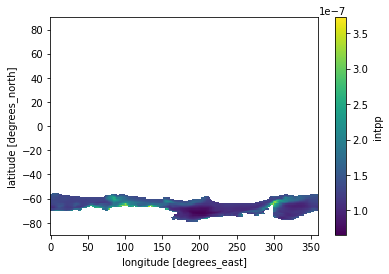

In [31]:
new_mean[variable].plot()

In [32]:
new_mean.to_netcdf(path = "Data/{}_{}_{}_20yr.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

##### Difference calculation

In [33]:
# Calculate percentage difference
historical = xarray.open_dataset("Data/{}_{}_historical_20yr.nc".format(variable, model))
new = xarray.open_dataset("Data/{}_{}_{}_20yr.nc".format(variable, model, experiment))

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    intpp    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

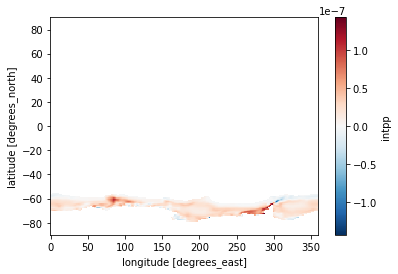

In [34]:
difference = new - historical
difference[variable].plot()
difference

In [35]:
difference.to_netcdf(path = "Data/{}_{}_{}_absolute.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

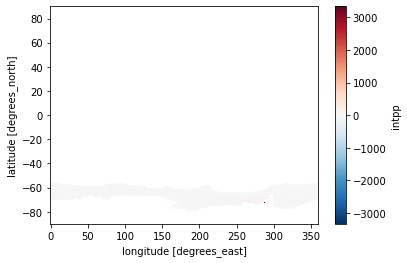

In [36]:
percentage = (difference/historical)*100
percentage[variable].plot()

In [37]:
percentage

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    intpp    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [38]:
percentage.to_netcdf(path = "Data/{}_{}_{}_percentage.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

#### Summary values

In [40]:
mean = (percentage.mean())[variable].values
max_value = (percentage.max())[variable].values
min_value = (percentage.min())[variable].values

mean_abs = (difference.mean())[variable].values
max_value_abs = (difference.max())[variable].values
min_value_abs = (difference.min())[variable].values

print("Mean change = {}% {}\n Max inc = {}% {}\n Max dec = {}% {}".format(mean, mean_abs, 
                                                                                                          max_value, max_value_abs,
                                                                                                          min_value, min_value_abs))

Mean change = 19.55724334716797% 1.763018531164562e-08
 Max inc = 3331.927001953125% 1.4363880040946242e-07
 Max dec = -34.37553787231445% -1.1356553386576707e-07


In [41]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "w")
summary.write("{} {}\n\nOverall:\nMean change = {}% {}\nMax inc = {}% {}\nMax dec = {}% {}".format(variable, model,
                                                                                                                                   mean, mean_abs, 
                                                                                                          max_value, max_value_abs,
                                                                                                          min_value, min_value_abs))
summary.close()

#### Apply mask

In [42]:
inc = gpd.read_file("Shapes/{}_inc.shp".format(model), crs = "EPSG:4326")
dec = gpd.read_file("Shapes/{}_dec.shp".format(model), crs = "EPSG:4326")

##### Increasing

In [43]:
nc = xarray.open_dataset("Data/{}_{}_{}_cropped.nc".format(variable, model, experiment))

nc.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
nc.rio.write_crs("epsg:4326", inplace=True)

inc_area = nc.rio.clip(inc.geometry.values, crs = 4326, drop = False, all_touched = True)
inc_area

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360, time: 1032)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    spatial_ref  int64 0
Data variables:
    intpp        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Wed Aug 03 10:52:01 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            intpp
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/045fe0c8-76be-44ac-8b8a-2c48f9dd3910
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

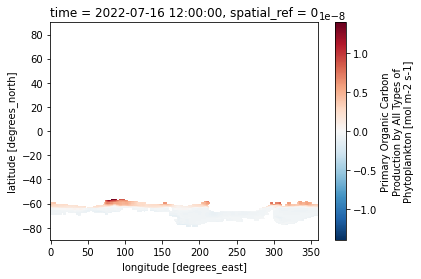

In [44]:
plotting = inc_area.sel(time = "2022-07")
plotting[variable].plot()

In [45]:
vars_list = list(inc_area.data_vars)  
for var in vars_list:  
    del inc_area[var].attrs['grid_mapping']


inc_area.to_netcdf(path = "Data/{}_{}_{}_inc.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

##### Decreasing

In [46]:
dec_area = nc.rio.clip(dec.geometry.values, crs = 4326, drop = False, all_touched = True)
dec_area

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360, time: 1032)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    spatial_ref  int64 0
Data variables:
    intpp        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Wed Aug 03 10:52:01 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            intpp
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/045fe0c8-76be-44ac-8b8a-2c48f9dd3910
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

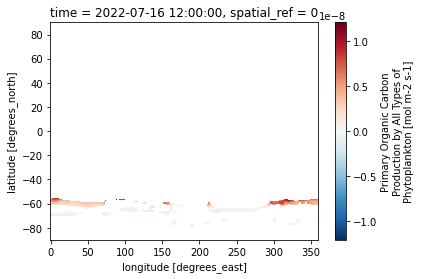

In [47]:
plotting = dec_area.sel(time = "2022-07")
plotting[variable].plot()

In [48]:
vars_list = list(dec_area.data_vars)  
for var in vars_list:  
    del dec_area[var].attrs['grid_mapping']


dec_area.to_netcdf(path = "Data/{}_{}_{}_dec.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

#### Zonal Percentage Change Summary 

In [49]:
inc = gpd.read_file("Shapes/{}_inc.shp".format(model), crs = "EPSG:4326")
dec = gpd.read_file("Shapes/{}_dec.shp".format(model), crs = "EPSG:4326")

##### Increasing

In [50]:
nc = xarray.open_dataset("Data/{}_{}_{}_percentage.nc".format(variable, model, experiment))

nc.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
nc.rio.write_crs("epsg:4326", inplace=True)

inc_area = nc.rio.clip(inc.geometry.values, crs = 4326, drop = False, all_touched = True)
inc_area

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    spatial_ref  int64 0
Data variables:
    intpp        (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

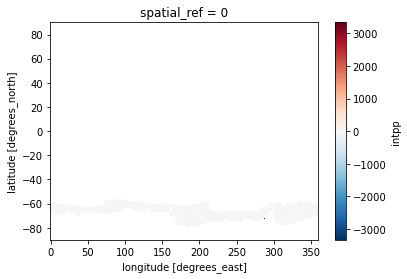

In [51]:
inc_area[variable].plot()

In [52]:
ab = xarray.open_dataset("Data/{}_{}_{}_absolute.nc".format(variable, model, experiment))

ab.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
ab.rio.write_crs("epsg:4326", inplace=True)

ab_inc_area = ab.rio.clip(inc.geometry.values, crs = 4326, drop = False, all_touched = True)
ab_inc_area

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    spatial_ref  int64 0
Data variables:
    intpp        (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

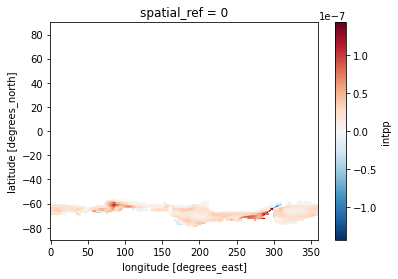

In [53]:
ab_inc_area[variable].plot()

In [54]:
inc_mean = (inc_area.mean())[variable].values
inc_max_value = (inc_area.max())[variable].values
inc_min_value = (inc_area.min())[variable].values

inc_mean_abs = (ab_inc_area.mean())[variable].values
inc_max_value_abs = (ab_inc_area.max())[variable].values
inc_min_value_abs = (ab_inc_area.min())[variable].values

print("Mean change = {}% {}\n Max inc = {}% {}\n Max dec = {}% {}\n".format(inc_mean, inc_mean_abs, 
                                                                            inc_max_value, inc_max_value_abs,
                                                                            inc_min_value, inc_min_value_abs))

Mean change = 23.48166275024414% 2.1115907244961818e-08
 Max inc = 3331.927001953125% 1.4363880040946242e-07
 Max dec = -28.403287887573242% -1.1356553386576707e-07



In [62]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\n\n\nIncreasing zone:\nMean change = {}% {}\nMax inc = {}% {}\nMax dec = {}% {}\n".format(inc_mean, inc_mean_abs, 
                                                                            inc_max_value, inc_max_value_abs,
                                                                            inc_min_value, inc_min_value_abs))
summary.close()

##### Decreasing

In [56]:
dec_area = nc.rio.clip(dec.geometry.values, crs = 4326, drop = False, all_touched = True)
dec_area

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    spatial_ref  int64 0
Data variables:
    intpp        (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

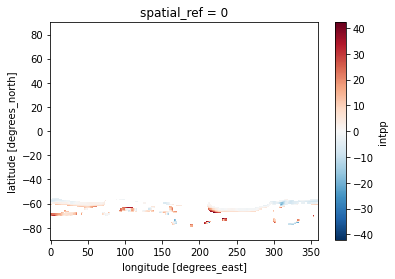

In [57]:
dec_area[variable].plot()

In [58]:
ab_dec_area = ab.rio.clip(dec.geometry.values, crs = 4326, drop = False, all_touched = True)
ab_dec_area

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    spatial_ref  int64 0
Data variables:
    intpp        (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

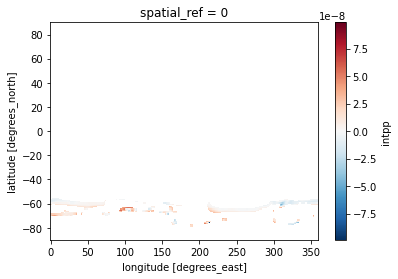

In [59]:
ab_dec_area[variable].plot()

In [60]:
dec_mean = (dec_area.mean())[variable].values
dec_max_value = (dec_area.max())[variable].values
dec_min_value = (dec_area.min())[variable].values

dec_mean_abs = (ab_dec_area.mean())[variable].values
dec_max_value_abs = (ab_dec_area.max())[variable].values
dec_min_value_abs = (ab_dec_area.min())[variable].values

print("Mean change = {}% {}\n Max inc = {}% {}\n Max dec = {}% {}\n".format(dec_mean, dec_mean_abs, 
                                                                            dec_max_value, dec_max_value_abs,
                                                                            dec_min_value, dec_min_value_abs))

Mean change = 3.822483777999878% 4.318965185490242e-09
 Max inc = 42.145057678222656% 5.623809329335927e-08
 Max dec = -34.37553787231445% -9.879262563572411e-08



In [63]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\n\n\nDecreasing zone:\nMean change = {}% {}\nMax inc = {}% {}\nMax dec = {}% {}\n".format(dec_mean, dec_mean_abs, 
                                                                            dec_max_value, dec_max_value_abs,
                                                                            dec_min_value, dec_min_value_abs))
summary.close()

## Absolute map

##### historical

In [72]:
# Annual mean at 2014
historical = xarray.open_dataset("Data/{}_{}_historical_cropped.nc".format(variable, model))
historical = historical.drop_vars("spatial_ref")
historical

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1980)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    intpp    (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Wed Aug 03 10:52:46 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variable_id:            intpp
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/f9aad0a5-1554-4d4b-9056-5578caee367d
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [73]:
historical_end = historical.sel(time = "2014")
historical_end

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 12)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 2014-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    intpp    (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Wed Aug 03 10:52:46 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variable_id:            intpp
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/f9aad0a5-1554-4d4b-9056-5578caee367d
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, year: 1)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * year     (year) int64 2014
Data variables:
    intpp    (year, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

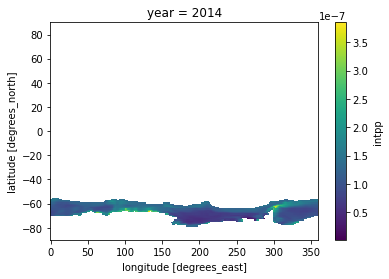

In [74]:
historical_mean = historical_end.groupby("time.year").mean("time")
historical_mean[variable].plot()
historical_mean

In [75]:
historical_mean.to_netcdf(path = "Data/{}_{}_historical_2014.nc".format(variable, model), mode = "w", format = "NETCDF4")

##### ssp585

In [76]:
# Annual mean at 2100
new = xarray.open_dataset("Data/{}_{}_{}_cropped.nc".format(variable, model, experiment))
new = new.drop_vars("spatial_ref")
new

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1032)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    intpp    (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Wed Aug 03 10:52:01 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            intpp
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/045fe0c8-76be-44ac-8b8a-2c48f9dd3910
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [77]:
new_end = new.sel(time = "2100")
new_end

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 12)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 2100-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    intpp    (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Wed Aug 03 10:52:01 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            intpp
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/045fe0c8-76be-44ac-8b8a-2c48f9dd3910
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, year: 1)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * year     (year) int64 2100
Data variables:
    intpp    (year, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

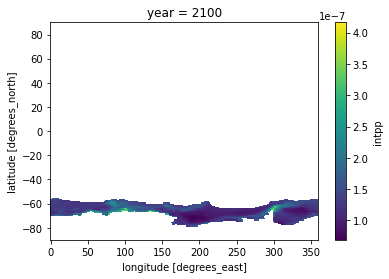

In [78]:
new_mean = new_end.groupby("time.year").mean("time")
new_mean[variable].plot()
new_mean

In [79]:
new_mean.to_netcdf(path = "Data/{}_{}_{}_2100.nc".format(variable, model, experiment), mode = "w", format = "NETCDF4")

##### Summary values

In [80]:
print("Mean at 2014 is: {}".format(historical_mean.mean()[variable].values))
print("Mean at 2100 is: {}".format(new_mean.mean()[variable].values))

Mean at 2014 is: 1.1859734172503522e-07
Mean at 2100 is: 1.3507916207800008e-07


##### Mapping

In [81]:
inc = gpd.read_file("Shapes/{}_inc_remapped_improved.shp".format(model))
dec = gpd.read_file("Shapes/{}_dec_remapped_improved.shp".format(model))

In [82]:
# Finding max/min value between the two years
old = xarray.open_dataset("Data/{}_{}_historical_2014.nc".format(variable, model))
new = xarray.open_dataset("Data/{}_{}_{}_2100.nc".format(variable, model, experiment))

In [83]:
lat_old = old['lat'].values 
lon_old = old['lon'].values
var_old = old[variable].values

var_old = np.nanmean(var_old, axis = 0) 

old_max = np.nanmax(var_old)
old_min = np.nanmin(var_old)
print(old_max, old_min)


var_old, lon_old = add_cyclic_point(var_old, coord=lon_old)
x, y = np.meshgrid(lon_old, lat_old)

3.8503302e-07 1.1540902e-09


/tmp/ipykernel_336567/3715887452.py:5: RuntimeWarning: Mean of empty slice


In [84]:
lat_new = new['lat'].values 
lon_new = new['lon'].values
var_new = new[variable].values

var_new = np.nanmean(var_new, axis = 0) 

new_max = np.nanmax(var_new)
new_min = np.nanmin(var_new)
print(new_max, new_min)


var_new, lon_new = add_cyclic_point(var_new, coord=lon_new)
x_new, y_new = np.meshgrid(lon_new, lat_new)

4.16419e-07 6.87495e-08


/tmp/ipykernel_336567/1500621824.py:5: RuntimeWarning: Mean of empty slice


In [85]:
overall_max = max(old_max, new_max)
overall_min = min(old_min, new_min)
print(overall_max, overall_min)

4.16419e-07 1.1540902e-09


/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteratio

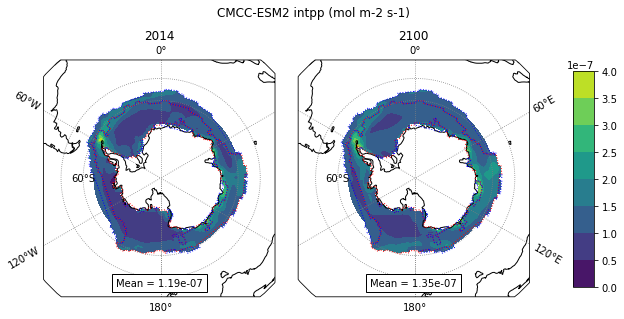

In [88]:
fig = plt.figure(figsize=[10, 5])
ax1 = fig.add_subplot(1, 2, 1, projection=cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90))
ax2 = fig.add_subplot(1, 2, 2, projection=cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90),
                               sharex=ax1, sharey=ax1)
fig.subplots_adjust(wspace=0.1)

plt.suptitle("{} {} ({})".format(model, variable, unit))


# 2014 plot
ax1.set_extent([-180, 180, -90, -40], cartopy.crs.PlateCarree())

gl1 = ax1.gridlines(crs = cartopy.crs.PlateCarree(),
                  draw_labels = True,
                  color = 'grey',
                  linestyle = ':',
                  y_inline = True,
                  x_inline = False) 

gl1.right_labels = False

gl1.ylabel_style = {'size': 10}
gl1.xlabel_style = {'size': 10}

gl1.ylocator = mticker.FixedLocator([-60, -50])

plt.draw()
for ea in gl1.label_artists:
    if ea[0]== 'lat':
        tx = ea[2]
        xy = tx.get_position()
        if xy[0]!=-90:
            tx.set_position([-90, xy[1]])



ax1.title.set_text('2014')

p = ax1.contourf(x, y, var_old,
                vmax = overall_max, vmin = overall_min,
                cmap = 'viridis',
                transform = cartopy.crs.PlateCarree())

ax1.coastlines()

ax1.add_geometries(inc['geometry'], 
                  cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90),
                  facecolor = 'none', 
                  edgecolor = 'red',
                  linestyle = ':')

ax1.add_geometries(dec['geometry'], 
                  cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90),
                  facecolor = 'none', 
                  edgecolor = 'blue',
                  linestyle = ':')


mean2014 = AnchoredText("Mean = {0:.2e}".format(historical_mean.mean()[variable].values), loc="lower center")
ax1.add_artist(mean2014)


# 2100 plot
ax2.set_extent([-180, 180, -90, -40], cartopy.crs.PlateCarree())

gl2 = ax2.gridlines(crs = cartopy.crs.PlateCarree(),
                  draw_labels = True,
                  color = 'grey',
                  linestyle = ':',
                  y_inline = True,
                  x_inline = False) 

gl2.left_labels = False

gl2.ylabel_style = {'size': 10}
gl2.xlabel_style = {'size': 10}

gl2.ylocator = mticker.FixedLocator([-60, -50])

plt.draw()
for ea in gl2.label_artists:
    if ea[0]== 'lat':
        tx = ea[2]
        xy = tx.get_position()
        if xy[0]!=-90:
            tx.set_position([-90, xy[1]])

ax2.title.set_text('2100')

p2 = ax2.contourf(x_new, y_new, var_new,
                vmax = overall_max, vmin = overall_min,
                cmap = 'viridis',
                transform = cartopy.crs.PlateCarree())

ax2.coastlines()

ax2.add_geometries(inc['geometry'], 
                  cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90),
                  facecolor = 'none', 
                  edgecolor = 'red',
                  linestyle = ':')

ax2.add_geometries(dec['geometry'], 
                  cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90),
                  facecolor = 'none', 
                  edgecolor = 'blue',
                  linestyle = ':')

mean2100 = AnchoredText("Mean = {0:.2e}".format(new_mean.mean()[variable].values), loc="lower center")
ax2.add_artist(mean2100)



### Colorbar
fig.subplots_adjust(right=0.8) # Move all subplots 0.2 away from the right
cbar_ax = fig.add_axes([0.86, 0.2, 0.03, 0.6]) # Define position and size of new element (distance from left, distance from bottom, width, height)
fig.colorbar(p, cax=cbar_ax)


plt.savefig("output/CMCC-ESM2/{}_{}_2014vs2100.png".format(variable, model))

plt.show()

## Percentage Change map

In [89]:
nc = xarray.open_dataset("Data/{}_{}_{}_percentage.nc".format(variable, model, experiment))
nc

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    intpp    (lat, lon) float32 ...

In [90]:
lat = nc['lat'].values 
lon = nc['lon'].values
var = nc[variable].values

var_max = np.nanmax(var)
var_min = np.nanmin(var)
label = abs(max([var_min, var_max], key = abs))
print(var_max, var_min)

var, lon = add_cyclic_point(var, coord=lon)
x, y = np.meshgrid(lon, lat)

3331.927 -34.375538


In [91]:
inc = gpd.read_file("Shapes/{}_inc_remapped_improved.shp".format(model))
dec = gpd.read_file("Shapes/{}_dec_remapped_improved.shp".format(model))

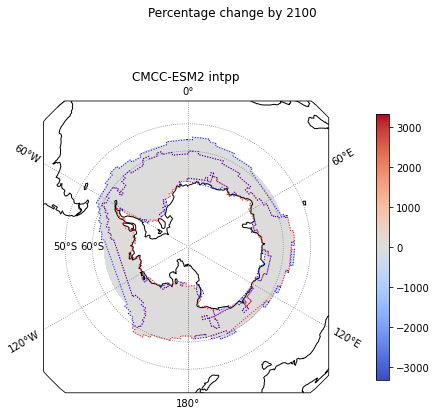

In [94]:
fig = plt.figure(figsize=[7, 7])
ax1 = fig.add_subplot(1, 1, 1, projection=cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90))


plt.suptitle("Percentage change by 2100")


ax1.set_extent([-180, 180, -90, -40], cartopy.crs.PlateCarree())

gl1 = ax1.gridlines(crs = cartopy.crs.PlateCarree(),
                  draw_labels = True,
                  color = 'grey',
                  linestyle = ':',
                  y_inline = True,
                  x_inline = False) 


gl1.ylabel_style = {'size': 10}
gl1.xlabel_style = {'size': 10}

gl1.ylocator = mticker.FixedLocator([-60, -50])

plt.draw()
for ea in gl1.label_artists:
    if ea[0]== 'lat':
        tx = ea[2]
        xy = tx.get_position()
        if xy[0]!=-90:
            tx.set_position([-90, xy[1]])



ax1.title.set_text("{} {}".format(model, variable))

divnorm = colors.TwoSlopeNorm(vmin = -label, vcenter = 0., vmax = label)
#divnorm = colors.TwoSlopeNorm(vcenter = 0.)

p = ax1.pcolor(x, y, var, 
              cmap = 'coolwarm', norm = divnorm, transform = cartopy.crs.PlateCarree() )


ax1.coastlines()

ax1.add_geometries(inc['geometry'], 
                  cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90),
                  facecolor = 'none', 
                  edgecolor = 'red',
                  linestyle = ':')

ax1.add_geometries(dec['geometry'], 
                  cartopy.crs.Orthographic(central_longitude = 0, central_latitude=-90),
                  facecolor = 'none', 
                  edgecolor = 'blue',
                  linestyle = ':')

cb = plt.colorbar(p, shrink=0.7, pad = 0.12)

plt.savefig("output/CMCC-ESM2/{}_{}_percentage_change.png".format(variable, model))

plt.show()

## Mean regression 

### Total


In [6]:
# Change in annual mean value 
nc = xarray.open_dataset("Data/{}_{}_{}_cropped.nc".format(variable, model, experiment))
nc = nc.drop_vars("spatial_ref")
nc

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1032)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    intpp    (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Wed Aug 03 10:52:01 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            intpp
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/045fe0c8-76be-44ac-8b8a-2c48f9dd3910
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [7]:
spatial_mean = nc.groupby("time").mean(["lat", "lon"])
spatial_mean

<xarray.Dataset>
Dimensions:  (time: 1032)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    intpp    (time) float32 2.693e-07 1.528e-07 1.048e-07 ... 3.882e-07 4.09e-07

In [8]:
year_mean = spatial_mean.groupby("time.year").mean("time")
year_mean

<xarray.Dataset>
Dimensions:  (year: 86)
Coordinates:
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
Data variables:
    intpp    (year) float32 1.194e-07 1.236e-07 ... 1.392e-07 1.351e-07

In [9]:
var_mean = year_mean[variable].values

In [10]:
time = year_mean['year'].values
time

array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025,
       2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036,
       2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047,
       2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058,
       2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069,
       2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080,
       2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091,
       2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100])

In [11]:
yearly_summer = []
yearly_winter = []

In [12]:
for i in time:
    year = spatial_mean.sel(time = "{}".format(i))
    
    season_mean = year.groupby("time.season").mean("time")

    summer = season_mean.sel(season = "DJF")[variable].values
    summer = summer.tolist()
    winter = season_mean.sel(season = "JJA")[variable].values
    winter = winter.tolist()
    
    yearly_summer.append(summer)
    yearly_winter.append(winter)
    

In [13]:
data = {'Year': time,
        'Annual': var_mean,
        'Summer': yearly_summer,
        'Winter': yearly_winter
        }

df = pd.DataFrame(data, columns= ['Year', 'Annual', 'Summer', 'Winter'])
df = df.assign(Model = "{}".format(model))
df

,Year,Annual,Summer,Winter,Model
0,2015,1.194259e-07,2.851978e-07,1.851725e-09,CMCC-ESM2
1,2016,1.235865e-07,2.975450e-07,1.959667e-09,CMCC-ESM2
2,2017,1.173060e-07,2.767252e-07,2.361555e-09,CMCC-ESM2
3,2018,1.169631e-07,2.756947e-07,2.080679e-09,CMCC-ESM2
4,2019,1.175467e-07,2.735012e-07,2.631948e-09,CMCC-ESM2
...,...,...,...,...,...
81,2096,1.407386e-07,2.924099e-07,2.732463e-09,CMCC-ESM2
82,2097,1.421923e-07,2.934366e-07,2.233650e-09,CMCC-ESM2
83,2098,1.429333e-07,2.945891e-07,2.284340e-09,CMCC-ESM2
84,2099,1.391752e-07,2.910251e-07,2.392745e-09,CMCC-ESM2


In [14]:
df.to_csv("csv/{}_{}_whole.csv".format(model, variable), index = False, header=True)

#### Plotting


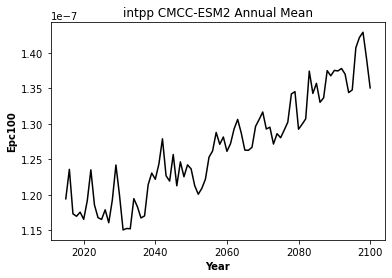

In [15]:
fig, ax = plt.subplots()

ax.plot(time, var_mean, 'k')
#ax.plot(time, yearly_summer, 'r')
#ax.plot(time, yearly_winter, 'b')

ax.title.set_text("{} {} Annual Mean".format(variable, model))

ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Epc100")
plt.xlabel("Year")

#plt.savefig("output/{}_{}_{}_projection_annual_mean.png".format(variable, model, experiment))

plt.show()

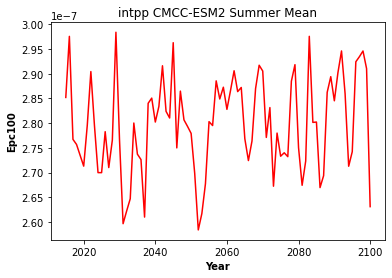

In [16]:
fig, ax = plt.subplots()

#ax.plot(time, var_mean, 'k')
ax.plot(time, yearly_summer, 'r')
#ax.plot(time, yearly_winter, 'b')

ax.title.set_text("{} {} Summer Mean".format(variable, model))

ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Epc100")
plt.xlabel("Year")

#plt.savefig("output/{}_{}_{}_projection_summer_mean.png".format(variable, model, experiment))

plt.show()

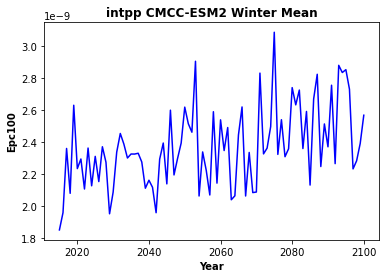

In [17]:
fig, ax = plt.subplots()

#ax.plot(time, var_mean, 'k')
#ax.plot(time, yearly_summer, 'r')
ax.plot(time, yearly_winter, 'b')

plt.title("{} {} Winter Mean".format(variable, model),fontweight="bold")

ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Epc100")
plt.xlabel("Year")

#plt.savefig("output/{}_{}_{}_projection_winter_mean.png".format(variable, model, experiment))

plt.show()

In [36]:
annual_inflection = 2034.4

annual_point = np.where(time == int(annual_inflection))[0].tolist()
annual_label = int(annual_inflection)
annual_position = (annual_label, var_mean[annual_point][0])


# summer_inflection = 2052.9

# summer_point = np.where(time == int(summer_inflection))[0].tolist()
# summer_label = int(summer_inflection)
# summer_position = (summer_label, yearly_summer[summer_point[0]])


# winter_inflection = 2052.9

# winter_point = np.where(time == int(winter_inflection))[0].tolist()
# winter_label = int(winter_inflection)
# winter_position = (winter_label, yearly_winter[winter_point[0]])

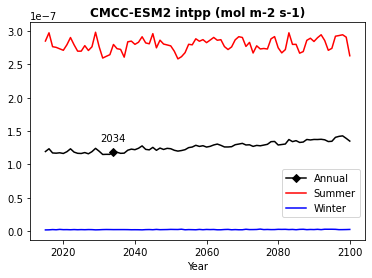

In [49]:
fig, ax = plt.subplots()

ax.plot(time, var_mean, '-kD', markevery=annual_point, label = "Annual")
ax.plot(time, yearly_summer, '-r', label = "Summer")
ax.plot(time, yearly_winter, '-b', label = "Winter")

plt.annotate(annual_label, annual_position, textcoords="offset points", xytext=(0,10), ha='center') 
#plt.annotate(summer_label, summer_position, textcoords="offset points",xytext=(0,12), ha='center') 
#plt.annotate(winter_label, winter_position, textcoords="offset points",xytext=(0,12), ha='center') 

plt.title("{} {} ({})".format(model, variable, unit), fontweight="bold")

#ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
#ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

#plt.ylabel("Epc100")
plt.xlabel("Year")

# bbox_to_anchor specify the position (x,y) of box in graph from the corner of the box specified by loc
plt.legend(loc="lower right", bbox_to_anchor=(1, 0.08))

plt.savefig("output/CMCC-ESM2/{}_{}_{}_mean_projection_whole.png".format(variable, model, experiment))

plt.show()

### Zonal

##### Increasing zone

In [18]:
inc = xarray.open_dataset("Data/{}_{}_{}_inc.nc".format(variable, model, experiment))
inc = inc.drop_vars("spatial_ref")
inc

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1032)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    intpp    (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Wed Aug 03 10:52:01 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            intpp
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/045fe0c8-76be-44ac-8b8a-2c48f9dd3910
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [19]:
inc_spatial_mean = inc.groupby("time").mean(["lat", "lon"])
inc_spatial_mean

<xarray.Dataset>
Dimensions:  (time: 1032)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    intpp    (time) float32 2.739e-07 1.526e-07 ... 3.854e-07 4.128e-07

In [20]:
inc_year_mean = inc_spatial_mean.groupby("time.year").mean("time")
inc_year_mean

<xarray.Dataset>
Dimensions:  (year: 86)
Coordinates:
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
Data variables:
    intpp    (year) float32 1.143e-07 1.181e-07 1.115e-07 ... 1.38e-07 1.334e-07

In [21]:
inc_mean = inc_year_mean[variable].values

In [22]:
time = inc_year_mean['year'].values

In [23]:
inc_yearly_summer = []
inc_yearly_winter = []

In [24]:
for i in time:
    year = inc_spatial_mean.sel(time = "{}".format(i))
    
    season_mean = year.groupby("time.season").mean("time")

    summer = season_mean.sel(season = "DJF")[variable].values
    summer = summer.tolist()
    winter = season_mean.sel(season = "JJA")[variable].values
    winter = winter.tolist()
    
    inc_yearly_summer.append(summer)
    inc_yearly_winter.append(winter)
    

In [25]:
data = {'Year': time,
        'Annual': inc_mean,
        'Summer': inc_yearly_summer,
        'Winter': inc_yearly_winter
        }

df = pd.DataFrame(data, columns= ['Year', 'Annual', 'Summer', 'Winter'])
df = df.assign(Model = "{}".format(model))
df

,Year,Annual,Summer,Winter,Model
0,2015,1.143395e-07,2.843754e-07,1.208383e-09,CMCC-ESM2
1,2016,1.181382e-07,2.956735e-07,1.309583e-09,CMCC-ESM2
2,2017,1.115203e-07,2.739157e-07,1.768932e-09,CMCC-ESM2
3,2018,1.123080e-07,2.759745e-07,1.370643e-09,CMCC-ESM2
4,2019,1.117603e-07,2.705425e-07,1.896129e-09,CMCC-ESM2
...,...,...,...,...,...
81,2096,1.388872e-07,2.947791e-07,2.045007e-09,CMCC-ESM2
82,2097,1.404119e-07,2.955997e-07,1.688385e-09,CMCC-ESM2
83,2098,1.413406e-07,2.969035e-07,1.705765e-09,CMCC-ESM2
84,2099,1.379532e-07,2.935244e-07,1.780531e-09,CMCC-ESM2


In [26]:
df.to_csv("csv/{}_{}_inc.csv".format(model, variable), index = False, header=True)

##### Decreasing zone

In [27]:
dec = xarray.open_dataset("Data/{}_{}_{}_dec.nc".format(variable, model, experiment))
dec = dec.drop_vars("spatial_ref")
dec

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1032)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    intpp    (time, lat, lon) float32 ...
Attributes: (12/50)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Wed Aug 03 10:52:01 2022: cdo remapdis,r360x180 D...
    source:                 CMCC-ESM2 (2017): \naerosol: MAM3\natmos: CAM5.3 ...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    ...                     ...
    variable_id:            intpp
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/045fe0c8-76be-44ac-8b8a-2c48f9dd3910
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [28]:
dec_spatial_mean = dec.groupby("time").mean(["lat", "lon"])
dec_spatial_mean

<xarray.Dataset>
Dimensions:  (time: 1032)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    intpp    (time) float32 2.542e-07 1.522e-07 1.205e-07 ... 4.06e-07 3.979e-07

In [29]:
dec_year_mean = dec_spatial_mean.groupby("time.year").mean("time")
dec_year_mean

<xarray.Dataset>
Dimensions:  (year: 86)
Coordinates:
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
Data variables:
    intpp    (year) float32 1.401e-07 1.46e-07 1.394e-07 ... 1.445e-07 1.415e-07

In [30]:
dec_mean = dec_year_mean[variable].values

In [31]:
dec_yearly_summer = []
dec_yearly_winter = []

In [32]:
for i in time:
    year = dec_spatial_mean.sel(time = "{}".format(i))
    
    season_mean = year.groupby("time.season").mean("time")

    summer = season_mean.sel(season = "DJF")[variable].values
    summer = summer.tolist()
    winter = season_mean.sel(season = "JJA")[variable].values
    winter = winter.tolist()
    
    dec_yearly_summer.append(summer)
    dec_yearly_winter.append(winter)
    

In [33]:
time = dec_year_mean['year'].values

In [34]:
data = {'Year': time,
        'Annual': dec_mean,
        'Summer': dec_yearly_summer,
        'Winter': dec_yearly_winter
        }

df = pd.DataFrame(data, columns= ['Year', 'Annual', 'Summer', 'Winter'])
df = df.assign(Model = "{}".format(model))
df

,Year,Annual,Summer,Winter,Model
0,2015,1.400749e-07,2.925552e-07,3.960151e-09,CMCC-ESM2
1,2016,1.459959e-07,3.116617e-07,4.084799e-09,CMCC-ESM2
2,2017,1.393523e-07,2.875387e-07,4.470151e-09,CMCC-ESM2
3,2018,1.333893e-07,2.758482e-07,4.385346e-09,CMCC-ESM2
4,2019,1.405543e-07,2.873116e-07,5.108951e-09,CMCC-ESM2
...,...,...,...,...,...
81,2096,1.484779e-07,2.868335e-07,5.019412e-09,CMCC-ESM2
82,2097,1.500194e-07,2.854760e-07,3.998137e-09,CMCC-ESM2
83,2098,1.499591e-07,2.866647e-07,4.101260e-09,CMCC-ESM2
84,2099,1.444741e-07,2.809439e-07,4.300555e-09,CMCC-ESM2


In [35]:
df.to_csv("csv/{}_{}_dec.csv".format(model, variable), index = False, header=True)

##### Plotting

In [50]:
inc_inflection = 2034.4

inc_point = np.where(time == int(inc_inflection))[0].tolist()
inc_label = int(inc_inflection)
inc_position = (inc_label, inc_mean[inc_point][0])


# dec_inflection = 

# dec_point = np.where(time == int(dec_inflection))[0].tolist()
# dec_label = int(dec_inflection)
# dec_position = (dec_label, dec_mean[dec_point][0])

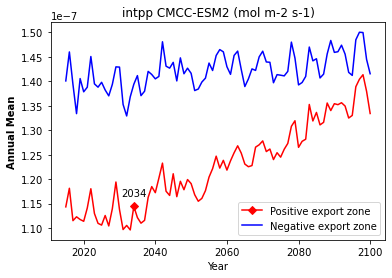

In [51]:
fig, ax = plt.subplots()


ax.plot(time, inc_mean, '-rD', markevery = inc_point, label = "Positive export zone")
ax.plot(time, dec_mean, '-b', label = "Negative export zone")


plt.annotate(inc_label, inc_position, textcoords="offset points", xytext=(0,10), ha='center') 
#plt.annotate(dec_label, dec_position, textcoords="offset points",xytext=(0,12), ha='center') 


plt.title("{} {} ({})".format(variable, model, unit))

#ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Annual Mean")
plt.xlabel("Year")

plt.legend()

plt.savefig("output/CMCC-ESM2/{}_{}_{}_annual_projection_by_zone.png".format(variable, model, experiment))

plt.show()

In [216]:
# inc_inflection = 2052.9

# inc_point = np.where(time == int(inc_inflection))[0].tolist()
# inc_label = int(inc_inflection)
# inc_position = (inc_label, inc_yearly_summer[inc_point[0]])


# dec_inflection = 

# dec_point = np.where(time == int(dec_inflection))[0].tolist()
# dec_label = int(dec_inflection)
# dec_position = (dec_label, dec_yearly_summer[dec_point[0]])

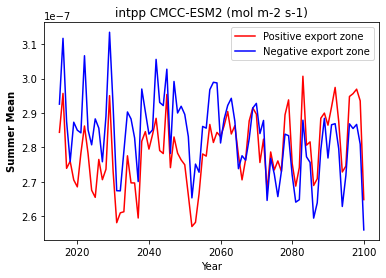

In [52]:
fig, ax = plt.subplots()


ax.plot(time, inc_yearly_summer, '-r', label = "Positive export zone")
ax.plot(time, dec_yearly_summer, '-b', label = "Negative export zone")

#plt.annotate(inc_label, inc_position, textcoords="offset points", xytext=(0,10), ha='center') 
#plt.annotate(dec_label, dec_position, textcoords="offset points",xytext=(0,12), ha='center') 


plt.title("{} {} ({})".format(variable, model, unit))

#ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Summer Mean")
plt.xlabel("Year")

plt.legend()

plt.savefig("output/CMCC-ESM2/{}_{}_{}_summer_projection_by_zone.png".format(variable, model, experiment))

plt.show()

In [53]:
# inc_inflection = 2052.9

# inc_point = np.where(time == int(inc_inflection))[0].tolist()
# inc_label = int(inc_inflection)
# inc_position = (inc_label, inc_yearly_winter[inc_point[0]])


# dec_inflection = 

# dec_point = np.where(time == int(dec_inflection))[0].tolist()
# dec_label = int(dec_inflection)
# dec_position = (dec_label, dec_yearly_winter[dec_point[0]])

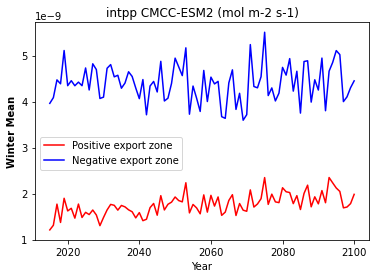

In [59]:
fig, ax = plt.subplots()


ax.plot(time, inc_yearly_winter, 'r', label = "Positive export zone")
ax.plot(time, dec_yearly_winter, 'b', label = "Negative export zone")

#plt.annotate(inc_label, inc_position, textcoords="offset points", xytext=(0,10), ha='center') 
#plt.annotate(dec_label, dec_position, textcoords="offset points",xytext=(0,12), ha='center') 


plt.title("{} {} ({})".format(variable, model, unit))

#ax.set_xlabel('xlabel', fontdict=dict(weight='bold'))
ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Winter Mean")
plt.xlabel("Year")

plt.legend(loc = "lower left", bbox_to_anchor = (0, 0.3))

plt.savefig("output/CMCC-ESM2/{}_{}_{}_winter_projection_by_zone.png".format(variable, model, experiment))

plt.show()

## Correlation with epc100

### 20year change correlation

#### Percentage

In [124]:
current_inc_per = xarray.open_dataarray("Data/{}_{}_{}_percentage.nc".format(variable, model, experiment))
exp_inc_per = xarray.open_dataarray("Data/epc100_{}_{}_percentage.nc".format(model, experiment))

In [125]:
cor_per = xarray.corr(current_inc_per, exp_inc_per, dim = ["lat", "lon"])
cor_per

<xarray.DataArray ()>
array(0.43579081)
Coordinates:
    depth    float64 100.0

In [85]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\n\n\nPercentage correlation with epc100: {}".format(cor_per.values))
summary.close()

#### Absolute

In [122]:
current_inc_abs = xarray.open_dataarray("Data/{}_{}_{}_absolute.nc".format(variable, model, experiment))
exp_inc_abs = xarray.open_dataarray("Data/epc100_{}_{}_absolute.nc".format(model, experiment))

In [123]:
cor_abs = xarray.corr(current_inc_abs, exp_inc_abs, dim = ["lat", "lon"])
cor

<xarray.DataArray ()>
array(0.71552843)
Coordinates:
    depth    float64 100.0

In [126]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\nAbsolute correlation with epc100: {}".format(cor_abs.values))
summary.close()

### Spatial correlation 

#### Increasing zone


In [127]:
current_inc = xarray.open_dataarray("Data/{}_{}_{}_inc.nc".format(variable, model, experiment),decode_coords="all")
current_inc

/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/backends/api.py:652: UserWarning: Variable(s) referenced in bounds not in variables: ['time_bnds']
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/backends/api.py:652: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacello']


<xarray.DataArray 'intpp' (time: 1032, lat: 180, lon: 360)>
[66873600 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    spatial_ref  int64 ...
Attributes:
    standard_name:  net_primary_mole_productivity_of_biomass_expressed_as_car...
    long_name:      Primary Organic Carbon Production by All Types of Phytopl...
    units:          mol m-2 s-1
    comment:        Vertically integrated total primary (organic carbon) prod...
    original_name:  pp
    cell_methods:   area: mean where sea depth: sum where sea time: mean
    history:        2021-01-20T13:15:10Z altered by CMOR: Converted type from...

In [128]:
epc = xarray.open_dataarray("Data/epc100_{}_{}_inc.nc".format(model, experiment), decode_coords="all")
epc

<xarray.DataArray 'epc100' (time: 1032, lat: 180, lon: 360)>
[66873600 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    depth        float64 ...
    spatial_ref  int64 ...
Attributes:
    standard_name:  sinking_mole_flux_of_particulate_organic_matter_expressed...
    long_name:      Downward Flux of Particulate Organic Carbon
    units:          mol m-2 s-1
    comment:        The phrase 'expressed_as' is used in the construction A_e...
    original_name:  expc (levid 19)
    cell_methods:   area: mean where sea time: mean
    history:        2021-01-20T13:14:42Z altered by CMOR: Treated scalar dime...

In [131]:
cor_inc = xarray.corr(current_inc, epc, dim = ["lat", "lon"])
cor_inc = cor_inc.groupby("time.year").mean("time")
cor_inc

<xarray.DataArray (year: 86)>
array([0.13326096, 0.12706103, 0.12162298, 0.08577575, 0.16008953,
       0.1145716 , 0.11962863, 0.15187317, 0.09465091, 0.16585225,
       0.15385034, 0.11700859, 0.07444621, 0.15578779, 0.11123489,
       0.19852793, 0.14790433, 0.140208  , 0.10092423, 0.13462626,
       0.14372294, 0.14291964, 0.1517181 , 0.14937719, 0.18322612,
       0.14445606, 0.13816482, 0.17157714, 0.15032526, 0.1615951 ,
       0.15170706, 0.14310155, 0.13727525, 0.11906911, 0.10550138,
       0.12359762, 0.11211525, 0.0838013 , 0.1001677 , 0.11032682,
       0.14358177, 0.11470583, 0.14404031, 0.19601047, 0.15956552,
       0.13736652, 0.142998  , 0.16529567, 0.19160477, 0.14467274,
       0.14456214, 0.18531046, 0.12769771, 0.15725826, 0.15138524,
       0.1730859 , 0.16588852, 0.13477546, 0.13391119, 0.13845507,
       0.12351106, 0.14172147, 0.15452058, 0.15327662, 0.09115374,
       0.16619334, 0.12411609, 0.08121264, 0.12359514, 0.15140393,
       0.1633944 , 0.16263295, 0.16449844, 0.16797726, 0.15247966,
       0.1648357 , 0.16114431, 0.14352501, 0.14595032, 0.09833534,
       0.08696058, 0.12376519, 0.14068263, 0.15300883, 0.09794679,
       0.11078157])
Coordinates:
    spatial_ref  int64 0
    depth        float64 100.0
  * year         (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100

In [145]:
time = cor_inc["year"].values

In [132]:
current_inc_season = current_inc.resample(time='QS-DEC').mean(dim="time")
current_inc_season['time']

<xarray.DataArray 'time' (time: 345)>
array([cftime.DatetimeNoLeap(2014, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 6, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time         (time) object 2014-12-01 00:00:00 ... 2100-12-01 00:00:00
    spatial_ref  int64 0

In [137]:
current_inc_summer = current_inc_season.sel(time=(current_inc_season.time.dt.month == 12))
current_inc_summer = current_inc_summer.sel(time = slice("2015","2100"))

In [138]:
current_inc_winter = current_inc_season.sel(time=(current_inc_season.time.dt.month == 6))

In [139]:
epc_inc_season = epc.resample(time='QS-DEC').mean(dim="time")

In [140]:
epc_inc_summer = epc_inc_season.sel(time=(epc_inc_season.time.dt.month == 12))
epc_inc_summer = epc_inc_summer.sel(time = slice("2015","2100"))
epc_inc_winter = epc_inc_season.sel(time=(epc_inc_season.time.dt.month == 6))

In [141]:
cor_inc_summer = xarray.corr(current_inc_summer, epc_inc_summer, dim = ["lat", "lon"])
cor_inc_summer

<xarray.DataArray (time: 86)>
array([ 1.42878700e-01,  1.10515985e-01,  4.83583530e-02,  1.43964049e-01,
        1.03499246e-01,  2.94468989e-02,  4.67890025e-02,  4.36283005e-02,
        6.24924507e-02,  5.85203595e-02,  1.52271913e-01, -7.96323474e-03,
        4.91237368e-02,  1.02243088e-01,  1.79922359e-01,  8.60657460e-02,
        1.39492209e-02, -8.13876672e-02,  9.63067232e-02, -1.67355216e-02,
        9.93783195e-02,  3.45183343e-02,  7.87368654e-02,  4.83921142e-02,
        1.23610046e-01, -2.96878869e-02,  8.94813941e-02,  1.72357744e-01,
        3.96021983e-02,  1.99024467e-01,  2.58738158e-02,  3.42034211e-02,
        1.25274672e-01,  2.37920296e-02,  1.37506405e-01,  7.62164098e-03,
       -2.95820578e-02, -6.39602433e-02,  9.86993994e-03, -2.47454515e-02,
       -7.65634523e-02,  3.25616057e-03,  1.10223631e-01, -4.83911330e-03,
       -2.90645274e-02,  1.58383734e-02,  1.90064587e-02,  1.04304264e-01,
        3.84877304e-02,  7.27037841e-02,  4.13175941e-02, -4.71612639e-02,
       -6.95745728e-04,  6.13566558e-02,  1.94147517e-02,  4.76521998e-02,
       -5.73701718e-02, -4.21906594e-02, -4.47720877e-02, -7.83758685e-02,
        1.06981912e-02,  1.45890971e-02, -1.13838226e-01, -5.17316555e-02,
        1.06698541e-01, -6.86042387e-02, -4.82725273e-02, -7.86954368e-02,
        1.12799030e-02, -5.50072578e-03,  2.59116449e-02, -5.39594008e-02,
       -1.39503843e-02, -1.97004066e-02, -1.90514959e-02, -6.26580933e-02,
        3.20309966e-02, -1.16933638e-04, -1.26353644e-01, -1.16915716e-01,
       -8.64653759e-02,  3.10090573e-02, -2.50717451e-02, -1.34415868e-01,
       -1.68771243e-01, -4.35703870e-01])
Coordinates:
  * time         (time) object 2015-12-01 00:00:00 ... 2100-12-01 00:00:00
    spatial_ref  int64 0
    depth        float64 100.0

In [142]:
cor_inc_winter = xarray.corr(current_inc_winter, epc_inc_winter, dim = ["lat", "lon"])
cor_inc_winter

<xarray.DataArray (time: 86)>
array([ 0.00437266,  0.04423888, -0.01065604, -0.03393697,  0.07774216,
       -0.03197422, -0.01881921, -0.00262084, -0.04548116,  0.03953846,
        0.03745212, -0.01216868, -0.08668139,  0.04598361, -0.01494846,
        0.08517203,  0.05844959,  0.02086398, -0.02619128,  0.02332009,
        0.01784641,  0.03478092,  0.07394905,  0.02442734,  0.07615454,
        0.03429143,  0.05795423,  0.01525708, -0.00611412,  0.00531071,
       -0.00416347,  0.01766818, -0.03896985, -0.06076739, -0.09537006,
       -0.03123677, -0.07471026, -0.07527862, -0.04535109, -0.06626822,
        0.01645411, -0.01674201,  0.01531325,  0.10217102,  0.03254311,
       -0.00246093, -0.01045686,  0.03210131,  0.09510253,  0.02056607,
        0.02320694,  0.02186324, -0.05443624,  0.06267603,  0.01740878,
        0.05336903,  0.05577298, -0.02884094,  0.00123888,  0.03044533,
       -0.02868098,  0.01730864,  0.03948958,  0.04487663, -0.07466458,
        0.03971756, -0.00230764, -0.08964672, -0.05229154, -0.00898799,
        0.01170494,  0.07381897,  0.07729538,  0.05636394,  0.03207238,
        0.02294213,  0.04094319,  0.04542449,  0.03804004,  0.03181049,
       -0.08627411, -0.05401632, -0.00173602, -0.01821473, -0.06846637,
       -0.01862163])
Coordinates:
  * time         (time) object 2015-06-01 00:00:00 ... 2100-06-01 00:00:00
    spatial_ref  int64 0
    depth        float64 100.0

In [146]:
data = {'Year': time,
        'Annual': cor_inc,
        'Summer': cor_inc_summer,
        'Winter': cor_inc_winter
        }

df = pd.DataFrame(data, columns= ['Year', 'Annual', 'Summer', 'Winter'])
df = df.assign(Model = "{}".format(model))
df

,Year,Annual,Summer,Winter,Model
0,2015,0.133261,0.142879,0.004373,CMCC-ESM2
1,2016,0.127061,0.110516,0.044239,CMCC-ESM2
2,2017,0.121623,0.048358,-0.010656,CMCC-ESM2
3,2018,0.085776,0.143964,-0.033937,CMCC-ESM2
4,2019,0.160090,0.103499,0.077742,CMCC-ESM2
...,...,...,...,...,...
81,2096,0.123765,0.031009,-0.054016,CMCC-ESM2
82,2097,0.140683,-0.025072,-0.001736,CMCC-ESM2
83,2098,0.153009,-0.134416,-0.018215,CMCC-ESM2
84,2099,0.097947,-0.168771,-0.068466,CMCC-ESM2


In [147]:
df.to_csv("csv/{}_{}_epc100_correlation_inc.csv".format(model, variable), index = False, header=True)

In [164]:
inc_mean = np.nanmean(cor_inc.values)
inc_mean_summer = np.nanmean(cor_inc_summer.values)
inc_mean_winter = np.nanmean(cor_inc_winter.values)

inc_max = np.nanmax(cor_inc.values)
inc_max_summer = np.nanmax(cor_inc_summer.values)
inc_max_winter = np.nanmax(cor_inc_winter.values)

inc_min = np.nanmin(cor_inc.values)
inc_min_summer = np.nanmin(cor_inc_summer.values)
inc_min_winter = np.nanmin(cor_inc_winter.values)

In [165]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\n\n\nSpatial correlation with epc100 in increasing zone:\n")
summary.write("Annual mean: {}\nAnnual max: {}\nAnnual min: {}".format(inc_mean, inc_max, inc_min))
summary.write("\n\nSummer mean: {}\nSummer max: {}\nSummer min: {}".format(inc_mean_summer, inc_max_summer, inc_min_summer))
summary.write("\n\nWinter mean: {}\nWinter max: {}\nWinter min: {}".format(inc_mean_winter, inc_max_winter, inc_min_winter))
summary.close()

#### Plotting

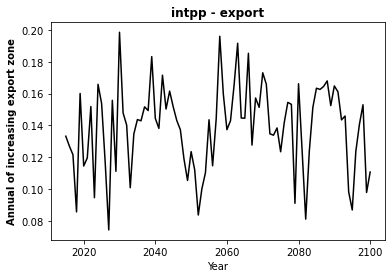

In [156]:
fig, ax = plt.subplots()

ax.plot(time, cor_inc, 'k')
plt.title("{} - export".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Annual of increasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_epc100_{}_annual_inc_correlation.png".format(model, variable, model))

plt.show()

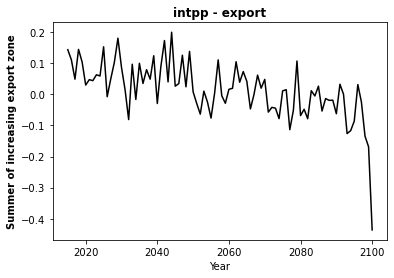

In [157]:
fig, ax = plt.subplots()

ax.plot(time, cor_inc_summer, 'k')
plt.title("{} - export".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Summer of increasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_epc100_{}_summer_inc_correlation.png".format(model, variable, model))

plt.show()

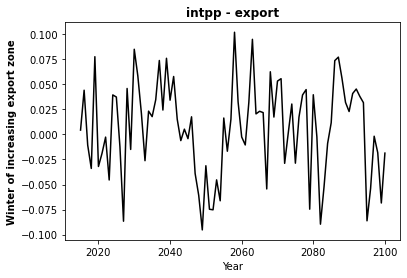

In [158]:
fig, ax = plt.subplots()

ax.plot(time, cor_inc_winter, 'k')
plt.title("{} - export".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Winter of increasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_epc100_{}_winter_inc_correlation.png".format(model, variable, model))

plt.show()

#### Decreasing zone


In [6]:
current_dec = xarray.open_dataarray("Data/{}_{}_{}_dec.nc".format(variable, model, experiment),decode_coords="all")
current_dec

/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/backends/api.py:652: UserWarning: Variable(s) referenced in bounds not in variables: ['time_bnds']
/home/jasmine/anaconda3/envs/newenv2/lib/python3.9/site-packages/xarray/backends/api.py:652: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacello']


<xarray.DataArray 'intpp' (time: 1032, lat: 180, lon: 360)>
[66873600 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    spatial_ref  int64 ...
Attributes:
    standard_name:  net_primary_mole_productivity_of_biomass_expressed_as_car...
    long_name:      Primary Organic Carbon Production by All Types of Phytopl...
    units:          mol m-2 s-1
    comment:        Vertically integrated total primary (organic carbon) prod...
    original_name:  pp
    cell_methods:   area: mean where sea depth: sum where sea time: mean
    history:        2021-01-20T13:15:10Z altered by CMOR: Converted type from...

In [7]:
epc_dec = xarray.open_dataarray("Data/epc100_{}_{}_dec.nc".format(model, experiment), decode_coords="all")
epc_dec

<xarray.DataArray 'epc100' (time: 1032, lat: 180, lon: 360)>
[66873600 values with dtype=float32]
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    depth        float64 ...
    spatial_ref  int64 ...
Attributes:
    standard_name:  sinking_mole_flux_of_particulate_organic_matter_expressed...
    long_name:      Downward Flux of Particulate Organic Carbon
    units:          mol m-2 s-1
    comment:        The phrase 'expressed_as' is used in the construction A_e...
    original_name:  expc (levid 19)
    cell_methods:   area: mean where sea time: mean
    history:        2021-01-20T13:14:42Z altered by CMOR: Treated scalar dime...

In [8]:
cor_dec = xarray.corr(current_dec, epc_dec, dim = ["lat", "lon"])
cor_dec = cor_dec.groupby("time.year").mean("time")
cor_dec

<xarray.DataArray (year: 86)>
array([-0.04908645, -0.06545896, -0.05018407, -0.04277457,  0.0072047 ,
       -0.07831747, -0.04888756, -0.06772293, -0.10701216, -0.04248819,
        0.00340924, -0.02046924, -0.04529198,  0.00611234, -0.05186653,
       -0.01855766, -0.01499022, -0.01577456, -0.0835901 , -0.05304122,
        0.02389061,  0.00144489,  0.07217702, -0.02801903, -0.06354374,
       -0.0617922 , -0.03587752, -0.06332881, -0.02996195,  0.00762637,
       -0.00053217, -0.02863754, -0.06127995, -0.00133673, -0.03100994,
        0.00539062, -0.04721644, -0.08078036, -0.04124657,  0.02556881,
        0.03307324,  0.00787683, -0.01317241, -0.03996531, -0.05523162,
       -0.04291718,  0.013512  ,  0.03054604, -0.01079591, -0.04039739,
        0.02329993,  0.03895439, -0.02727274,  0.01189553,  0.03048038,
        0.05079867,  0.00586894, -0.04196004,  0.02971185, -0.0061785 ,
       -0.03960266, -0.03382368, -0.01040409,  0.00096242, -0.0204148 ,
       -0.00540307, -0.06280171, -0.0239163 ,  0.02074393,  0.00421809,
        0.02860934,  0.0249248 ,  0.01627579, -0.0168053 , -0.03380385,
       -0.04109954, -0.02090325, -0.01360116,  0.00043539,  0.01750991,
       -0.00595507, -0.08214883, -0.05735122, -0.01872099, -0.06972577,
       -0.05291058])
Coordinates:
    spatial_ref  int64 0
    depth        float64 100.0
  * year         (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100

In [10]:
time = cor_dec["year"].values

In [11]:
current_dec_season = current_dec.resample(time='QS-DEC').mean(dim="time")
current_dec_season['time']

<xarray.DataArray 'time' (time: 345)>
array([cftime.DatetimeNoLeap(2014, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 6, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time         (time) object 2014-12-01 00:00:00 ... 2100-12-01 00:00:00
    spatial_ref  int64 0

In [12]:
current_dec_summer = current_dec_season.sel(time=(current_dec_season.time.dt.month == 12))
current_dec_summer = current_dec_summer.sel(time = slice("2015","2100"))

In [13]:
current_dec_winter = current_dec_season.sel(time=(current_dec_season.time.dt.month == 6))

In [15]:
epc_dec_season = epc_dec.resample(time='QS-DEC').mean(dim="time")

In [16]:
epc_dec_summer = epc_dec_season.sel(time=(epc_dec_season.time.dt.month == 12))
epc_dec_summer = epc_dec_summer.sel(time = slice("2015","2100"))
epc_dec_winter = epc_dec_season.sel(time=(epc_dec_season.time.dt.month == 6))

In [17]:
cor_dec_summer = xarray.corr(current_dec_summer, epc_dec_summer, dim = ["lat", "lon"])
cor_dec_summer

<xarray.DataArray (time: 86)>
array([ 0.04283018,  0.08978636,  0.06245928,  0.1675687 ,  0.01437576,
       -0.00588161, -0.08947344,  0.02988678, -0.03331374, -0.07518274,
        0.07087919, -0.0554407 , -0.00122447,  0.08326251,  0.10679888,
        0.12407734,  0.1251613 , -0.14071765, -0.09914166, -0.07912925,
        0.12413157,  0.26068654,  0.15691074, -0.06931896,  0.05613757,
        0.00367322,  0.09027606,  0.1841976 ,  0.10176774,  0.23229228,
        0.08582631, -0.01355068,  0.23434124, -0.04052647,  0.20551799,
        0.04476069,  0.0237121 ,  0.10362245,  0.12451226, -0.04547355,
        0.00469249, -0.01642825, -0.03314651, -0.01251879,  0.09011592,
        0.10306708, -0.02104761,  0.09870279,  0.06787483,  0.15430528,
        0.01194882,  0.05741953,  0.06579983,  0.04110146,  0.02341263,
        0.19303585,  0.12448941,  0.11067333,  0.04874686,  0.06004326,
        0.12493351,  0.13029259,  0.0393759 ,  0.08545874,  0.22471161,
        0.17448067,  0.22239532,  0.15656626,  0.21784481,  0.17678098,
        0.16704092,  0.17972698,  0.2183037 ,  0.13531335,  0.10824332,
        0.12895628,  0.27425317,  0.15922918,  0.16308217,  0.08085659,
        0.10103519,  0.22582769,  0.18418741,  0.16219725,  0.05854708,
       -0.50947604])
Coordinates:
  * time         (time) object 2015-12-01 00:00:00 ... 2100-12-01 00:00:00
    spatial_ref  int64 0
    depth        float64 100.0

In [18]:
cor_dec_winter = xarray.corr(current_dec_winter, epc_dec_winter, dim = ["lat", "lon"])
cor_dec_winter

<xarray.DataArray (time: 86)>
array([-0.36519447, -0.30720803, -0.37214013, -0.24909664, -0.22000312,
       -0.42539632, -0.32913034, -0.37716698, -0.43704233, -0.298216  ,
       -0.30864071, -0.3039428 , -0.31889765, -0.20463335, -0.37942922,
       -0.29179919, -0.23824768, -0.29488143, -0.37763272, -0.28773882,
       -0.23787822, -0.25201169, -0.08678745, -0.3022442 , -0.35850825,
       -0.33625655, -0.28354804, -0.38657761, -0.33887335, -0.33133352,
       -0.23975955, -0.29794352, -0.41504362, -0.35170057, -0.30152022,
       -0.30182707, -0.37218084, -0.38318928, -0.37594164, -0.26003907,
       -0.13643011, -0.23393054, -0.22093208, -0.26384372, -0.36437918,
       -0.350946  , -0.23023024, -0.214202  , -0.24455644, -0.34049371,
       -0.21458334, -0.200139  , -0.36143756, -0.24677565, -0.2159687 ,
       -0.15938937, -0.26229003, -0.34550116, -0.24947031, -0.2191058 ,
       -0.30116962, -0.30393964, -0.25056002, -0.24312057, -0.25816176,
       -0.32755775, -0.37461366, -0.3026973 , -0.2167994 , -0.28760029,
       -0.21603678, -0.20113576, -0.19494024, -0.29381521, -0.33029251,
       -0.31538169, -0.30706848, -0.27801513, -0.27522129, -0.15008964,
       -0.27222761, -0.36673381, -0.41867387, -0.32901973, -0.36905307,
       -0.34624372])
Coordinates:
  * time         (time) object 2015-06-01 00:00:00 ... 2100-06-01 00:00:00
    spatial_ref  int64 0
    depth        float64 100.0

In [19]:
data = {'Year': time,
        'Annual': cor_dec,
        'Summer': cor_dec_summer,
        'Winter': cor_dec_winter
        }

df = pd.DataFrame(data, columns= ['Year', 'Annual', 'Summer', 'Winter'])
df = df.assign(Model = "{}".format(model))
df

,Year,Annual,Summer,Winter,Model
0,2015,-0.049086,0.042830,-0.365194,CMCC-ESM2
1,2016,-0.065459,0.089786,-0.307208,CMCC-ESM2
2,2017,-0.050184,0.062459,-0.372140,CMCC-ESM2
3,2018,-0.042775,0.167569,-0.249097,CMCC-ESM2
4,2019,0.007205,0.014376,-0.220003,CMCC-ESM2
...,...,...,...,...,...
81,2096,-0.082149,0.225828,-0.366734,CMCC-ESM2
82,2097,-0.057351,0.184187,-0.418674,CMCC-ESM2
83,2098,-0.018721,0.162197,-0.329020,CMCC-ESM2
84,2099,-0.069726,0.058547,-0.369053,CMCC-ESM2


In [20]:
df.to_csv("csv/{}_{}_epc100_correlation_dec.csv".format(model, variable), index = False, header=True)

In [21]:
dec_mean = np.nanmean(cor_dec.values)
dec_mean_summer = np.nanmean(cor_dec_summer.values)
dec_mean_winter = np.nanmean(cor_dec_winter.values)

dec_max = np.nanmax(cor_dec.values)
dec_max_summer = np.nanmax(cor_dec_summer.values)
dec_max_winter = np.nanmax(cor_dec_winter.values)

dec_min = np.nanmin(cor_dec.values)
dec_min_summer = np.nanmin(cor_dec_summer.values)
dec_min_winter = np.nanmin(cor_dec_winter.values)

In [22]:
summary = open("output/{}/{}_summary.txt".format(model, variable), "a")
summary.write("\n\n\nSpatial correlation with epc100 in decreasing zone:\n")
summary.write("Annual mean: {}\nAnnual max: {}\nAnnual min: {}".format(dec_mean, dec_max, dec_min))
summary.write("\n\nSummer mean: {}\nSummer max: {}\nSummer min: {}".format(dec_mean_summer, dec_max_summer, dec_min_summer))
summary.write("\n\nWinter mean: {}\nWinter max: {}\nWinter min: {}".format(dec_mean_winter, dec_max_winter, dec_min_winter))
summary.close()

#### Plotting

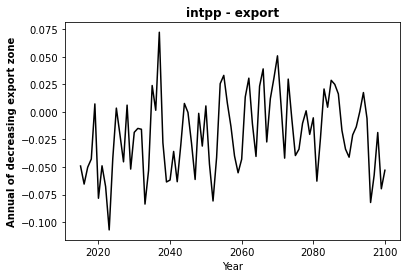

In [23]:
fig, ax = plt.subplots()

ax.plot(time, cor_dec, 'k')
plt.title("{} - export".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Annual of decreasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_epc100_{}_annual_dec_correlation.png".format(model, variable, model))

plt.show()

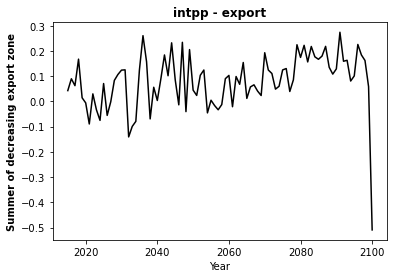

In [24]:
fig, ax = plt.subplots()

ax.plot(time, cor_dec_summer, 'k')
plt.title("{} - export".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Summer of decreasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_epc100_{}_summer_dec_correlation.png".format(model, variable, model))

plt.show()

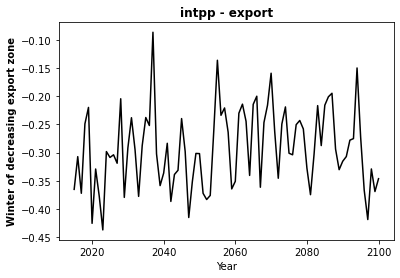

In [25]:
fig, ax = plt.subplots()

ax.plot(time, cor_dec_winter, 'k')
plt.title("{} - export".format(variable), fontweight = "bold")

ax.set_ylabel('xlabel', fontdict=dict(weight='bold'))

plt.ylabel("Winter of decreasing export zone")
plt.xlabel("Year")

plt.savefig("output/{}/{}_epc100_{}_winter_dec_correlation.png".format(model, variable, model))

plt.show()